In [ ]:
# A quick script to compare the detrended and isochrone output of SM-emp on the
# calibration dataset to Gaia and the Yee library.

In [2]:
# compare SMP derived values to Gaia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import scipy
import datetime 

gaia_values = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/gaia_values.csv')
apf_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_stellar_properties/all_apf/11Jan2022/specmatch_results_11Jan2022.csv')
apf_data_still_with_clipping = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_stellar_properties/all_apf/10Dec2021/specmatch_results_10Dec2021.csv')
#apf_data_old_resamp = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_stellar_properties/all_apf/05Nov2021/specmatch_results_all.csv') # SM-Emp values derived from APF spectra
apf_data_old_resamp = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_stellar_properties/all_apf/specmatch_results_current.csv') # SM-Emp values derived from APF spectra
#apf_data_detrended = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/SM_steller_properties/specmatch_results_detrended.csv') # SM-Emp values derived from APF spectra, detrended in run_smemp_apf.ipynb
hires_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/lincomb_results_detrend.csv') # SM-Emp values derived from HIRES spectra (detrended)
yee_data = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/yee_library_full.csv') # library values
apf_log_file =  pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/apf_log_full_current.csv')

In [4]:
def get_names(sim_name):
    # get Gaia and 2MASS names (for creating flags and for later isochrone analysis)
    result_table = Simbad.query_objectids(sim_name)
    names = result_table.to_pandas()['ID'].to_list()
    gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
    two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
    (gaia_source_id,) = gaia_name
    (id_2MASS,) = two_MASS_name
    return gaia_source_id, id_2MASS

def query_gaia_data(gaia_source_id):
    # Gaia properties to flag stars outside library bounds
    #gaia_data =  pd.read_csv('./Gaia_properties_by_HIP_name.csv') # gaia stellar properties (only R and Teff)
    query1 = "SELECT source_id, ra, dec, parallax, parallax_error, teff_val, radius_val  FROM gaiadr2.gaia_source WHERE source_id = " + str(gaia_source_id)
    job = Gaia.launch_job(query1)
    gaia_data = job.get_results()
    return gaia_data

In [4]:
len(np.where(apf_data['failure_code'] == 0)[0])

865

In [14]:
# how many are cut by which cuts

no_iod_mask = apf_data['iodine_flag'] == 0
iod_mask = apf_data['iodine_flag'] == 1
binary_mask = apf_data['binary_flag'] == 1
not_star_mask = apf_data['non-stellar_flag'] == 1
no_SM_fail_mask = apf_data['failure_code'] == 0
fail_mask = apf_data['failure_code'] == 1
no_iso_fail_mask = (apf_data['iso_fail_flag'] == 0) * (apf_data['iso_Teff'] > 0)
iso_fail_mask = (apf_data['iso_fail_flag'] == 1) | (apf_data['iso_Teff'] == 0)
in_bounds_mask = (apf_data['Teff_bounds_flag'] == 0)*(apf_data['R_bounds_flag'] == 0)
#not_star = np.zeros(len(apf_results))
#not_star[[i for i, s in enumerate(apf_data['Type']) if ('*' not in s)]] = 1
#SB = apf_results['Type'] == 'SB*'
#no_SB = apf_results['Type'] != 'SB*'
#nan_parallax = 'Nan parallax' in str(apf_data['warnings'])
#no_gaia_name = 'Failed to find Gaia' in str(apf_data['warnings']) * (not 'Failed to find 2MASS' in str(apf_data['warnings']))
#no_2MASS_name = 'Failed to find 2MASS' in str(apf_data['warnings']) * (not 'Failed to find Gaia' in str(apf_data['warnings']))
#no_both_names = 'Failed to find 2MASS' in str(apf_data['warnings']) * ('Failed to find Gaia' in str(apf_data['warnings']))

total_stars = len(apf_data)
num_no_iodine = len(np.where(no_iod_mask)[0])
num_iod = len(np.where(iod_mask)[0])
binary = len(np.where(binary_mask)[0])
not_star = len(np.where(not_star_mask[0]))
num_no_SM_fail = len(np.where([no_SM_fail_mask])[0])
num_SM_fail = len(np.where([fail_mask])[0])
num_no_iso_fail = len(np.where([no_iso_fail_mask])[0])
num_iso_fail = len(np.where([iso_fail_mask])[0])
num_in_bounds = len(np.where([in_bounds_mask])[0])
#bad_objects_mask = ((apf_results['Type'] == 'SB*') | not_star).to_numpy()
#num_SB = len(np.where([SB])[0])
num_nan_parallax = len([i for i, s in enumerate(apf_data['warnings']) if ('Nan parallax' in s)]) 
num_no_gaia_name = len([i for i, s in enumerate(apf_data['warnings']) if ('Failed to find Gaia' in s) and not ('Failed to find 2MASS' in s)]) 
num_no_2MASS_name = len([i for i, s in enumerate(apf_data['warnings']) if ('Failed to find 2MASS' in s) and not ('Failed to find Gaia' in s)]) 
num_no_both_names = len([i for i, s in enumerate(apf_data['warnings']) if ('Failed to find Gaia' in s) and ('Failed to find 2MASS' in s)]) 
num_no_iod_no_SM_fail_no_iso_fail = len(np.where([no_iod*no_SM_fail*no_iso_fail])[0])
num_no_iod_no_SM_fail_in_bounds = len(np.where([no_iod*no_SM_fail*in_bounds])[0])
num_no_iod_no_SM_fail_no_iso_fail_in_bounds = len(np.where([no_iod*no_SM_fail*no_iso_fail*in_bounds])[0])
#num_no_iod_no_SM_fail_no_iso_fail_in_bounds_no_SB = len(np.where([no_iod*no_SM_fail*no_iso_fail*in_bounds_no_SB])[0])
use_stars = no_iod*no_SM_fail*no_iso_fail*in_bounds #np.invert(np.isnan(apf_data['iso_Teff'])) * (apf_data['iso_Teff'] > 0) # or maybe should use non iso value in this case
starlist = apf_data[use_stars]['Simbad_resolvable_name'] # list of stars with isochrone values

# define which to use for laser search  of residuals
# Not binaries or galaxies, no iodine, didn't fail SM, inside library region,
search_mask = np.invert(binary_mask) * np.invert(not_star_mask) *  no_iod_mask * in_bounds_mask * no_SM_fail_mask 
residual_search_list = apf_data['Simbad_resolvable_name'][search_mask]

# print diagnostics
print('TOTAL TARGET STARS: ' + str(total_stars))
print('   Including  ' + str(len((apf_data['Simbad_resolvable_name'])) - len(set(apf_data['Simbad_resolvable_name']))) + ' repeated stars (as listed by simbad name....)')
print('Total sucessful: ' + str(num_no_SM_fail))
print('Total failed: ' + str(num_SM_fail))
#print('without iodine: ' + str(no_iodine))
print('     ' + str(num_iod) + ' because spectra/um contains iodine.')
print('     ' + str(binary) + ' because is a known binary.')
print('     ' + str(not_star) + ' because known to be a non-stellar object.')
#print(num_SB + ' are spectroscopic binaries.')
print('Total ran with isoclassify: ' + str(num_no_iso_fail))
print('Total failed isoclassify OR all results zero: ' + str(num_iso_fail) + ' (plus ' + str(num_SM_fail) + ' failed SM so no attempt at isoclassify)')
print('     ' + str(num_no_gaia_name) + ' because no Gaia name found.')
print('     ' + str(num_no_2MASS_name) + ' because no 2MASS name found.')
print('     ' + str(num_no_both_names) + ' because no Gaia or 2MASS name found.')
print('     ' + str(num_nan_parallax) + ' because Gaia parallax returned Nan.')
print('Total within library bounds: ' + str(num_in_bounds))
print('     with ' + str(num_no_iod_no_SM_fail_no_iso_fail_in_bounds) + ' within bounds and no SM or isoclassify failure.')
print('     with ' + str(num_no_iod_no_SM_fail_in_bounds) + ' within bounds and no SM failure (but could fail isoclassify).')
print('TOTAL STARS SUCCESSFUL: ' + str(num_no_iod_no_SM_fail_no_iso_fail_in_bounds))
      
#print('no iodine no SM fail: ' + str(no_iod_no_SM_fail))
#print('no iodine no SM fail no iso fail: ' + str(no_iod_no_SM_fail_no_iso_fail))
#print('no iodine no SM fail no iso fail in bounds: ' + str(no_iod_no_SM_fail_no_iso_fail_in_bounds))

print('')
print('There were ' + str(len((starlist)) - len(set(starlist))) + ' repeated stars in the remaining ' +
      str(num_no_iod_no_SM_fail_no_iso_fail_in_bounds))

if len((apf_data['Simbad_resolvable_name'])) != len(set(apf_data['Simbad_resolvable_name'])):
    print('')
    print('The fact that there were repeats means the input spectra were not initially grouped by star correctly!')

dt = datetime.datetime.now()
print('')
print(str(len(residual_search_list)) + ' residuals to be searched.')
residual_search_list.to_csv('/mnt_home/azuckerman/BL_APF_DAP/residual_target_list_' + dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '.csv', index = False)

print('')
print('Timestamp: ' +  str(dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")))

TOTAL TARGET STARS: 902
   Including  2 repeated stars (as listed by simbad name....)
Total sucessful: 772
Total failed: 130
     23 because spectra/um contains iodine.
     97 because is a known binary.
     1 because known to be a non-stellar object.
Total ran with isoclassify: 657
Total failed isoclassify OR all results zero: 114 (plus 130 failed SM so no attempt at isoclassify)
     70 because no Gaia name found.
     8 because no 2MASS name found.
     14 because no Gaia or 2MASS name found.
     13 because Gaia parallax returned Nan.
Total within library bounds: 517
     with 432 within bounds and no SM or isoclassify failure.
     with 497 within bounds and no SM failure (but could fail isoclassify).
TOTAL STARS SUCCESSFUL: 432

There were 0 repeated stars in the remaining 432

The fact that there were repeats means the input spectra were not initially grouped by star correctly!

497 residuals to be searched.

Timestamp: 26Jan2022-10:56:58


/home/azuckerman/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/azuckerman/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [10]:
search_mask = np.invert(binary_mask) * np.invert(not_star_mask) *  no_iod_mask * in_bounds_mask * no_SM_fail_mask
#search_mask
residual_search_list = apf_data['Simbad_resolvable_name'][search_mask]
residual_search_list 

0      HIP96285
1      HIP96395
3      HIP96895
4      HIP97051
5       HIP9716
         ...   
890    HIP79702
891    HIP79755
894     HIP7981
898    HIP80008
899    HIP80093
Name: Simbad_resolvable_name, Length: 497, dtype: object

In [22]:
# how many are listed by TIC name (ie. are also TESS targets)
len([name for name in apf_data['name'] if name.startswith('TIC')])

51

In [207]:
# some stars are listed under different simbad resolvable names but the same HIP name. This should never happen becuase of how I group them...
# Which is this true for?

#repeats = len((apf_data['Simbad_resolvable_name'])) - len(set(apf_data['Simbad_resolvable_name']
import collections
repeats = [(item, count) for item, count in collections.Counter(apf_data['HIP_name']).items() if count > 1]
print(repeats)
apf_data[apf_data['HIP_name'] == 'HIP91262'] # --> Vega
apf_data[apf_data['HIP_name'] == 'HIP97649'] # --> GJ768
print(set(apf_log_file[apf_log_file['Simbad_resolvable_name'] == 'HIP97649']['Alt_names']))
print(set(apf_log_file[apf_log_file['Simbad_resolvable_name'] == 'GJ768']['Alt_names']))

[('None', 47), ('HIP91262', 2), ('HIP97649', 2)]
{"['TIC 70257116', 'PLX 4665', 'LSPM J1950+0852', 'ASCC 1075038', 'USNO-B1.0 0988-00511792', '* alf Aql', '*  53 Aql', '2E  4294', '8pc 194.44', 'ADS 13009 A', 'AG+08 2636', 'BD+08  4236', 'CCDM J19508+0852A', 'CSI+08  4236  1', 'Ci 20 1169', 'FK5  745', 'GAT  549', 'GC 27470', 'GCRV 12193', 'GEN# +1.00187642', 'GJ   768', 'HD 187642', 'HIC  97649', 'HIP  97649', 'HR  7557', 'IDS 19459+0836 A', 'IRAS 19483+0844', 'IRC +10441', 'JP11  3142', 'LFT 1499', 'LHS  3490', 'LTT 15795', 'N30 4388', 'NAME Altair', 'NLTT 48314', 'NSV 24910', 'PM 19484+0844', 'PMC 90-93   530', 'PPM 168779', 'RAFGL 2463', 'ROT  2857', 'SAO 125122', 'SKY# 37134', 'TD1 25537', 'UBV M  24205', 'UBV   16885', 'USNO 891', 'Zkh 297', 'uvby98 100187642', '2MASS J19504698+0852060', 'PLX 4665.00', '1ES 1948+08.7', '2E 1948.3+0844', '1RXS J195047.0+085159', 'WDS J19508+0852A', 'TYC 1058-3399-1', 'GSC 01058-03399', 'V* alf Aql', 'AKARI-FIS-V1 J1950472+085209', '2XMMi J195047.1

In [5]:
use_stars = no_iod*no_SM_fail*no_iso_fail*in_bounds #np.invert(np.isnan(apf_data['iso_Teff'])) * (apf_data['iso_Teff'] > 0) # or maybe should use non iso value in this case
starlist = apf_data[use_stars]['Simbad_resolvable_name'] # list of stars with isochrone values
starlist = list(set(starlist)) # remove repeats

# only use stars that have gaia values, and make sure they are in order
apf_results = pd.DataFrame(columns = apf_data.columns)
apf_results["Type"] = np.nan
apf_results["Types_list"] = np.nan
gaia_data = pd.DataFrame(columns = gaia_values.columns)
Simbad.add_votable_fields('otypes')
Simbad.add_votable_fields('otype(3)')
for sim_name in starlist:
    if not sim_name.startswith('NGC') and not sim_name.startswith('210610'):
    
       # try:
        gaia_source_id, id_2MASS = get_names(sim_name)
        gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
        gaia_row = gaia_row.median(axis = 0, skipna = True)

        if np.isnan(np.nanmedian(gaia_row['radius_val'])) or np.isnan(np.nanmedian(gaia_row['teff_val'])):
            print('Skipping ' + sim_name + ', either Teff or R is NaN in Gaia.')
            continue
        #print(len(gaia_data))
        #print(len(apf_results))
        gaia_data = gaia_data.append(gaia_row, ignore_index = True)
        
                
        # find out what the obejct type is
        table1 = Simbad.query_object(sim_name).to_pandas()
        otypes = table1['OTYPES']
        otypes_list = table1['OTYPES'][0].split('|')
        main_otype = table1['OTYPE_3'][0]
        apf_row = apf_data[apf_data['Simbad_resolvable_name'] == sim_name].iloc[0,:]   # for now to deal w/ repeats only take first row
        apf_row["Type"] = main_otype
        apf_row["Types_list"] = otypes_list
        #apf_results = apf_results.append(apf_data[apf_data['Simbad_resolvable_name'] == sim_name].iloc[0,:]) 
        apf_results = apf_results.append(apf_row)

        
#except Exception:
    #    print('Skipping ' + HIP_name + ', not found in gaia list.')
        
gaia_Teff_err = 324 # K
gaia_R_err_pcnt = 0.10 # percent!!

In [17]:
len(apf_results)


488

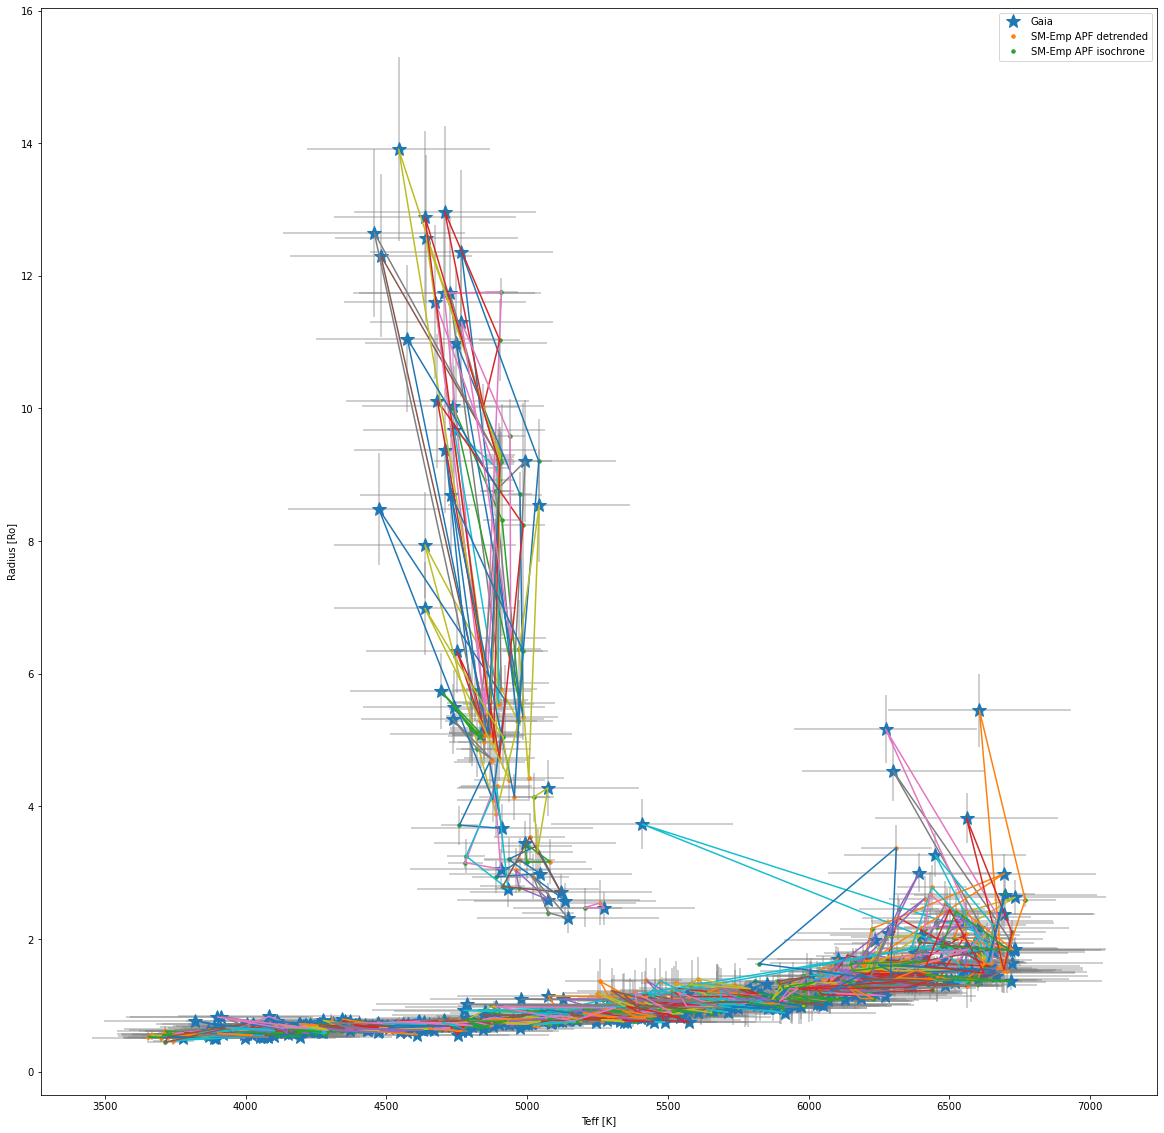

In [76]:
# OUTDATED AS OF 11/5/21!
plt.figure(figsize = [20,20])
#plt.subplot(211)
plt.plot(gaia_data['teff_val'], gaia_data['radius_val'], '*', markersize = 14, label = 'Gaia')
plt.errorbar(gaia_data['teff_val'], gaia_data['radius_val'], xerr = gaia_Teff_err, yerr = gaia_data['radius_val'] * gaia_R_err_pcnt, ls = 'None', color = 'gray', alpha = 0.5)
plt.plot(apf_results['Teff_detrended'], apf_results['radius_detrended'], '.',  markersize = 7, label = 'SM-Emp APF detrended')
plt.errorbar(apf_results['Teff_detrended'], apf_results['radius_detrended'], xerr= apf_results['u_Teff_detrended'], 
             yerr = apf_results['u_radius_detrended'], ls = 'None', color = 'gray', alpha = 0.5)
plt.plot(apf_results['iso_Teff'], apf_results['iso_radius'], '.',  markersize = 7, label = 'SM-Emp APF isochrone')
plt.errorbar(apf_results['iso_Teff'], apf_results['iso_radius'], xerr = [apf_results['iso_um_Teff'], apf_results['iso_um_Teff']],
             yerr = [apf_results['iso_um_radius'], apf_results['iso_um_radius']] , ls = 'None', color = 'gray', alpha = 0.5)
for row in range(len(apf_results)):
    plt.plot([apf_results['iso_Teff'].iloc[row], apf_results['Teff_detrended'].iloc[row], gaia_data['teff_val'].iloc[row], apf_results['iso_Teff'].iloc[row]],
             [apf_results['iso_radius'].iloc[row], apf_results['radius_detrended'].iloc[row], gaia_data['radius_val'].iloc[row], apf_results['iso_radius'].iloc[row]])
plt.xlabel('Teff [K]'); plt.ylabel('Radius [Ro]'); plt.legend()

Teff: 
   Isochrone is better for 229 stars and worse for 203 stars
Radius: 
   Isochrone is better for 319 stars and worse for 110 stars

Timestamp: 13Jan2022-13:20:35


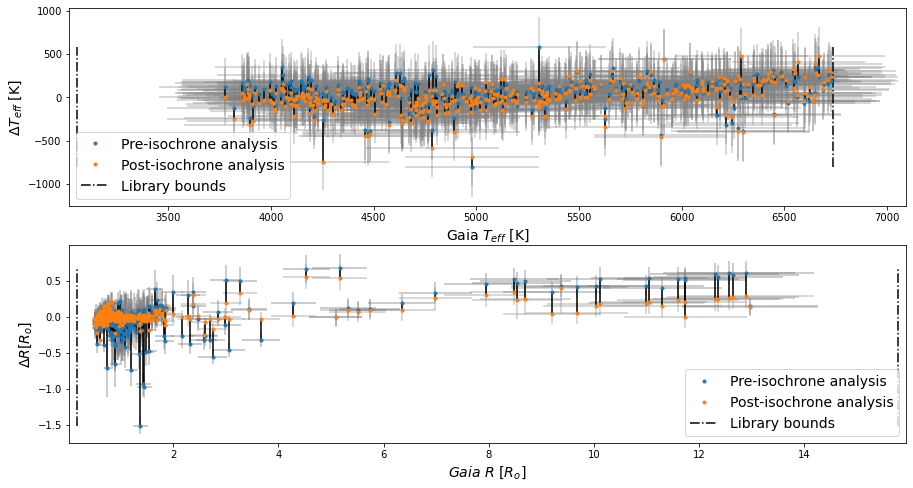

In [11]:
not_star = np.zeros(len(apf_results))
not_star[[i for i, s in enumerate(apf_results['Type']) if ('*' not in s)]] = 1
bad_objects_mask = ((apf_results['Type'] == 'SB*') | not_star).to_numpy()
mask = np.invert(bad_objects_mask) # omit SB's

gaia_Teff = gaia_data['teff_val'].to_numpy()[mask]
gaia_R = gaia_data['radius_val'].to_numpy()[mask]
apf_Teff = apf_results['iso_Teff'].to_numpy()[mask]
apf_R = apf_results['iso_radius'].to_numpy()[mask]
apf_Teff_up = apf_results['iso_up_Teff'].to_numpy()[mask]
apf_Teff_um = apf_results['iso_um_Teff'].to_numpy()[mask]
apf_R_up = apf_results['iso_up_radius'].to_numpy()[mask]
apf_R_um = apf_results['iso_um_radius'].to_numpy()[mask]
apf_Teff_u_det = apf_results['u_Teff_detrended'][mask].to_numpy()
apf_R_u_det = apf_results['u_radius_detrended'][mask].to_numpy()

delta_Teff_det = gaia_data['teff_val'].to_numpy()[mask] - apf_results['Teff_detrended'].to_numpy()[mask]
delta_R_det = gaia_data['radius_val'].to_numpy()[mask] - apf_results['radius_detrended'].to_numpy()[mask]
delta_Teff_iso = gaia_data['teff_val'].to_numpy()[mask] - apf_results['iso_Teff'].to_numpy()[mask]
delta_R_iso = gaia_data['radius_val'].to_numpy()[mask] - apf_results['iso_radius'].to_numpy()[mask] 
delta_R_R_iso = delta_R_iso/gaia_data['radius_val'].to_numpy()[mask]
delta_R_R_det = delta_R_det/gaia_data['radius_val'].to_numpy()[mask]

fs = 14
err_lw = 2
ms = 4
tick_fs = 14
label_fs = 16

plt.figure(figsize = [15,8])
plt.subplot(211)
good = 0; bad = 0
for row in range(len(apf_results[mask])):
    c = 'k'
    if abs(delta_Teff_det[row]) > abs(delta_Teff_iso[row]): 
    #    c = 'limegreen'
        good += 1
    elif abs(delta_Teff_det[row]) < abs(delta_Teff_iso[row]): 
    #    c = 'red'
        bad += 1
    plt.plot([gaia_Teff[row],gaia_Teff[row]], [delta_Teff_det[row], delta_Teff_iso[row]], color = c)
plt.plot(gaia_Teff, delta_Teff_det, '.', label = 'Pre-isochrone analysis')
#plt.plot(gaia_data['teff_val'][bad_objects_mask], delta_Teff_det[bad_objects_mask], '.', label = 'Not star or SB!!')
plt.errorbar(gaia_Teff, delta_Teff_det, yerr = np.sqrt(apf_Teff_u_det**2 + (gaia_Teff_err)**2), xerr = gaia_Teff_err,
             color = 'grey', alpha = 0.3, linewidth = err_lw, ls = 'None')
plt.plot(gaia_Teff, delta_Teff_iso, '.', label = 'Post-isochrone analysis') 
plt.errorbar(gaia_Teff, delta_Teff_iso, yerr = [np.sqrt(apf_Teff_up**2 + (gaia_Teff_err)**2), np.sqrt(apf_Teff_um**2 + (gaia_Teff_err)**2)], xerr = gaia_Teff_err,
             color = 'grey', alpha = 0.3, linewidth = err_lw, ls = 'None')
plt.vlines([3056, 6738], ymin = np.nanmin(delta_Teff_det), ymax = np.nanmax(delta_Teff_det), ls = '-.',  label = 'Library bounds') 
#plt.plot([],[], color = 'limegreen', label = 'Isochrone value better'); plt.plot([],[], color = 'red', label = 'Isochrone value worse'); plt.plot([],[], color = 'grey', alpha = 0.3, linewidth = 5, label = 'Uncertainty') # hack for legend
plt.margins(x=0.01)#plt.xlim([3500, 7500])
#plt.axis('equal')
plt.xlabel('Gaia $T_{eff}$ [K]',fontsize = fs); plt.ylabel('$\Delta T_{eff}$ [K]',fontsize = fs); plt.legend(fontsize = fs)
print('Teff: ')
print('   Isochrone is better for ' + str(good) + ' stars and worse for ' + str(bad) + ' stars')

plt.subplot(212)
good = 0; bad = 0
for row in range(len(apf_results[mask])):
    c = 'k'
    if abs(delta_R_det[row]) > abs(delta_R_iso[row]): 
   #     c = 'limegreen'
        good += 1
    elif abs(delta_R_det[row]) < abs(delta_R_iso[row]): 
    #    c = 'red'
        bad += 1
    plt.plot([gaia_R[row],gaia_R[row]], [delta_R_R_det[row], delta_R_R_iso[row]], color = c)
plt.plot(gaia_R, delta_R_R_det, '.', label = 'Pre-isochrone analysis')
delta_R_det_err = np.sqrt(apf_R_u_det**2 + (0.10*gaia_R)**2)
plt.errorbar(gaia_R, delta_R_R_det, yerr = delta_R_R_det * (delta_R_det_err/delta_R_det + 0.10), xerr = 0.10*gaia_R,
             color = 'grey', alpha = 0.4, linewidth = err_lw, ls = 'None')
plt.vlines([0.168, 15.781], ymin = np.nanmin(delta_R_R_det), ymax = np.nanmax(delta_R_R_det), ls = '-.',  label = 'Library bounds') 
delta_R_iso_up_err = np.sqrt(apf_R_up**2 + (0.10*gaia_R)**2)
delta_R_iso_um_err = np.sqrt(apf_R_um**2 + (0.10*gaia_R)**2)
plt.errorbar(gaia_R, delta_R_R_iso, yerr = [delta_R_R_det * (delta_R_iso_up_err/delta_R_det + 0.10), delta_R_R_det * (delta_R_iso_um_err/delta_R_det + 0.10)], xerr = 0.10*gaia_R,
             color = 'grey', alpha = 0.3, linewidth = err_lw, ls = 'None')
plt.plot(gaia_R, delta_R_R_iso, '.', label = 'Post-isochrone analysis')
#plt.plot([],[], color = 'limegreen', label = 'Isochrone value better'); plt.plot([],[], color = 'red', label = 'Isochrone value worse') # hack for legend
plt.margins(x=0.01)#plt.axis('equal')
plt.xlabel('$Gaia$ $R$ $[R_o]$',fontsize = fs); plt.ylabel('$\Delta R [R_o]$',fontsize = fs); plt.legend(fontsize = fs)
print('Radius: ')
print('   Isochrone is better for ' + str(good) + ' stars and worse for ' + str(bad) + ' stars')

print()
dt = datetime.datetime.now()
print('Timestamp: ' +  str(dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")))

Timestamp: 13Jan2022-13:21:08


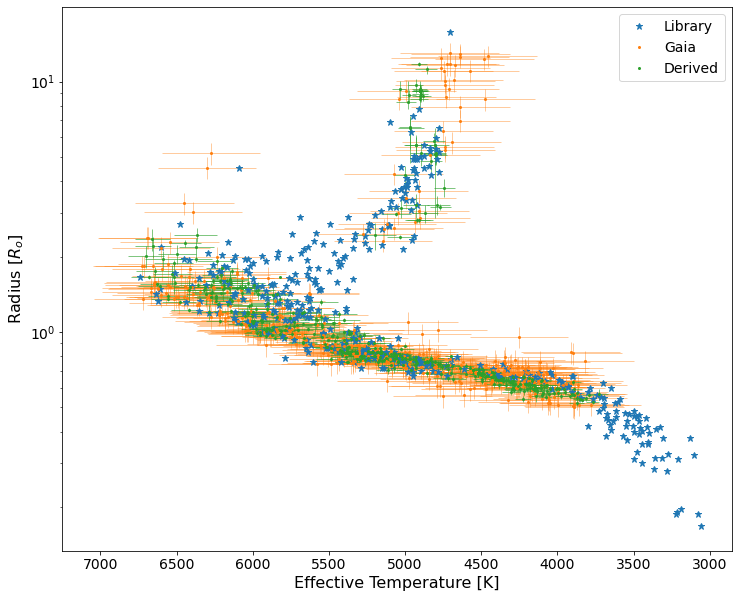

In [12]:
# plot an HR diagram

gaia_Teff = gaia_data['teff_val'].to_numpy()[mask]
gaia_R = gaia_data['radius_val'].to_numpy()[mask]
apf_Teff = apf_results['iso_Teff'].to_numpy()[mask]
apf_R = apf_results['iso_radius'].to_numpy()[mask]
apf_Teff_up = apf_results['iso_up_Teff'].to_numpy()[mask]
apf_Teff_um = apf_results['iso_um_Teff'].to_numpy()[mask]
apf_R_up = apf_results['iso_up_radius'].to_numpy()[mask]
apf_R_um = apf_results['iso_um_radius'].to_numpy()[mask]
gaia_Teff_err = 324 # K
gaia_R_err_pcnt = 0.10 # percent!!

plt.figure(figsize = [12,10])
plt.plot(yee_data['Teff [K]'], yee_data['R* [Rsun]'], '*', label ='Library', markersize = 7)
plt.plot(gaia_Teff, gaia_R, '.',  label = 'Gaia', markersize = 4)
plt.errorbar(gaia_Teff,gaia_R, xerr = gaia_Teff_err, yerr = gaia_R_err_pcnt * gaia_R, color = 'C1', ls = 'None', alpha = 0.4, lw = 1)
plt.plot(apf_Teff, apf_R, '.', label = 'Derived', markersize = 4)
plt.errorbar(apf_Teff, apf_R, xerr = [apf_Teff_up,apf_Teff_um], yerr = [apf_R_up, apf_R_um], color = 'C2', ls = 'None', alpha = 0.6, lw = 1)
#for i in range(len(gaia_R)):
#    plt.plot([gaia_Teff[i], apf_Teff[i]],[gaia_R[i], apf_R[i]], color = 'k', alpha = 0.5)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Effective Temperature [K]', fontsize = 16)
plt.ylabel('Radius [$R_o]$', fontsize = 16)
plt.gca().invert_xaxis()
plt.yscale('log')
plt.legend(fontsize = 14)

dt = datetime.datetime.now()
print('Timestamp: ' +  str(dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")))
#make the size of the crosses represetnt he error in each direction!

In [103]:
# Determine the RMS between Gaia and SM values for deternded vs isochrone values

RMS_Teff_det = np.sqrt(np.nanmean(delta_Teff_det[mask]**2))
RMS_R_det = np.sqrt(np.nanmean(delta_R_det[mask]**2))
RMS_Teff_iso = np.sqrt(np.nanmean(delta_Teff_iso[mask]**2))
RMS_R_iso = np.sqrt(np.nanmean(delta_R_iso[mask]**2))

reg1 = gaia_data['radius_val'][mask].to_numpy() < 1.0
reg2 = (gaia_data['radius_val'][mask].to_numpy() > 1.0) * (gaia_data['radius_val'][mask].to_numpy() <= 2.5)
reg3 = (gaia_data['radius_val'][mask].to_numpy() > 2.6) * (gaia_data['radius_val'][mask].to_numpy() <= 6)
reg4 = gaia_data['radius_val'][mask].to_numpy() > 6.0
RMS_R_det1 = np.sqrt(np.nanmean(delta_R_det[mask][reg1]**2))
RMS_R_det2 = np.sqrt(np.nanmean(delta_R_det[mask][reg2]**2))
RMS_R_det3 = np.sqrt(np.nanmean(delta_R_det[mask][reg3]**2))
RMS_R_det4 = np.sqrt(np.nanmean(delta_R_det[mask][reg4]**2))


print('Teff: ')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso,3)))
print('Radius: ')
print('All regions:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_iso,3)))

print('R < 1.0:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det1,3)))
print('1.0 < R < 2.5:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det2,3)))
print('2.5 < R < 6.0:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det3,3)))
print('6.0 < R :')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_det4,3)))

print()
dt = datetime.datetime.now()
print('Timestamp: ' +  str(dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")))

Teff: 
   RMS detrended to gaia: 153.701
   RMS isochrone to gaia: 157.027
Radius: 
All regions:
   RMS detrended to gaia: 1.26
   RMS isochrone to gaia: 0.588
R < 1.0:
   RMS detrended to gaia: 0.09
1.0 < R < 2.5:
   RMS detrended to gaia: 0.369
2.5 < R < 6.0:
   RMS detrended to gaia: 1.475
6.0 < R :
   RMS detrended to gaia: 5.237


In [13]:
# Determine the RMS between Gaia and SM values for deternded vs isochrone values
# AGAIN BUT IN DELTA R/R !

RMS_Teff_det = np.sqrt(np.nanmean(delta_Teff_det[mask]**2))
RMS_R_R_det = np.sqrt(np.nanmean(delta_R_det[mask]**2)) * 100
RMS_Teff_iso = np.sqrt(np.nanmean(delta_Teff_iso[mask]**2))
RMS_R_R_iso = np.sqrt(np.nanmean(delta_R_iso[mask]**2)) * 100

R_reg1 = gaia_data['radius_val'][mask].to_numpy() < 1.0
R_reg2 = (gaia_data['radius_val'][mask].to_numpy() > 1.0) * (gaia_data['radius_val'][mask].to_numpy() <= 2.5)
R_reg3 = (gaia_data['radius_val'][mask].to_numpy() > 2.6) * (gaia_data['radius_val'][mask].to_numpy() <= 6)
R_reg4 = gaia_data['radius_val'][mask].to_numpy() > 6.0

Teff_reg1 = gaia_data['teff_val'][mask].to_numpy() < 4500
Teff_reg2 = gaia_data['teff_val'][mask].to_numpy() >= 4500

RMS_R_R_det1 = np.sqrt(np.nanmean(delta_R_R_det[mask][R_reg1]**2)) * 100
RMS_R_R_det2 = np.sqrt(np.nanmean(delta_R_R_det[mask][R_reg2]**2)) * 100
RMS_R_R_det3 = np.sqrt(np.nanmean(delta_R_R_det[mask][R_reg3]**2)) * 100
RMS_R_R_det4 = np.sqrt(np.nanmean(delta_R_R_det[mask][R_reg4]**2)) * 100
RMS_R_R_det5 = np.sqrt(np.nanmean(delta_R_R_det[mask][Teff_reg1]**2)) * 100
RMS_R_R_det6 = np.sqrt(np.nanmean(delta_R_R_det[mask][Teff_reg2]**2)) * 100
RMS_R_R_iso1 = np.sqrt(np.nanmean(delta_R_R_iso[mask][R_reg1]**2)) * 100
RMS_R_R_iso2 = np.sqrt(np.nanmean(delta_R_R_iso[mask][R_reg2]**2)) * 100
RMS_R_R_iso3 = np.sqrt(np.nanmean(delta_R_R_iso[mask][R_reg3]**2)) * 100
RMS_R_R_iso4 = np.sqrt(np.nanmean(delta_R_R_iso[mask][R_reg4]**2)) * 100
RMS_R_R_iso5 = np.sqrt(np.nanmean(delta_R_R_iso[mask][Teff_reg1]**2)) * 100
RMS_R_R_iso6 = np.sqrt(np.nanmean(delta_R_R_iso[mask][Teff_reg2]**2)) * 100

RMS_Teff_det1 = np.sqrt(np.nanmean(delta_Teff_det[mask][R_reg1]**2)) 
RMS_Teff_det2 = np.sqrt(np.nanmean(delta_Teff_det[mask][R_reg2]**2)) 
RMS_Teff_det3 = np.sqrt(np.nanmean(delta_Teff_det[mask][R_reg3]**2)) 
RMS_Teff_det4 = np.sqrt(np.nanmean(delta_Teff_det[mask][R_reg4]**2)) 
RMS_Teff_det5 = np.sqrt(np.nanmean(delta_Teff_det[mask][Teff_reg1]**2)) 
RMS_Teff_det6 = np.sqrt(np.nanmean(delta_Teff_det[mask][Teff_reg2]**2)) 
RMS_Teff_iso1 = np.sqrt(np.nanmean(delta_Teff_iso[mask][R_reg1]**2)) 
RMS_Teff_iso2 = np.sqrt(np.nanmean(delta_Teff_iso[mask][R_reg2]**2)) 
RMS_Teff_iso3 = np.sqrt(np.nanmean(delta_Teff_iso[mask][R_reg3]**2)) 
RMS_Teff_iso4 = np.sqrt(np.nanmean(delta_Teff_iso[mask][R_reg4]**2)) 
RMS_Teff_iso5 = np.sqrt(np.nanmean(delta_Teff_iso[mask][Teff_reg1]**2)) 
RMS_Teff_iso6 = np.sqrt(np.nanmean(delta_Teff_iso[mask][Teff_reg2]**2)) 

print('------- RMS in Teff -------')
print('All radius regions: ')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso,3)))
print('R < 1.0:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det1,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso1,3)))
print('1.0 < R < 2.5:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det2,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso2,3)))
print('2.5 < R < 6.0:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det3,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso3,3)))
print('6.0 < R :')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det4,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso4,3)))
print('Teff < 4500:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det5,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso5,3)))
print('Teff >= 4500:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_Teff_det6,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_Teff_iso6,3)))
print('')
print('------- RMS in Radius -------')
print('All radius regions:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_R_det,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_R_iso,3)))
print('R < 1.0:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_R_det1,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_R_iso1,3)))
print('1.0 < R < 2.5:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_R_det2,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_R_iso2,3)))
print('2.5 < R < 6.0:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_R_det3,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_R_iso3,3)))
print('6.0 < R :')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_R_det4,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_R_iso4,3)))
print('Teff < 4500:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_R_det5,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_R_iso5,3)))
print('Teff >= 4500:')
print('   RMS detrended to gaia: ' + str(np.round(RMS_R_R_det6,3)))
print('   RMS isochrone to gaia: ' + str(np.round(RMS_R_R_iso6,3)))

print()
dt = datetime.datetime.now()
print('Timestamp: ' +  str(dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")))

------- RMS in Teff -------
All radius regions: 
   RMS detrended to gaia: 153.808
   RMS isochrone to gaia: 155.028
R < 1.0:
   RMS detrended to gaia: 123.814
   RMS isochrone to gaia: 113.206
1.0 < R < 2.5:
   RMS detrended to gaia: 190.312
   RMS isochrone to gaia: 199.058
2.5 < R < 6.0:
   RMS detrended to gaia: 170.614
   RMS isochrone to gaia: 186.02
6.0 < R :
   RMS detrended to gaia: 228.642
   RMS isochrone to gaia: 256.102
Teff < 4500:
   RMS detrended to gaia: 131.189
   RMS isochrone to gaia: 137.57
Teff >= 4500:
   RMS detrended to gaia: 160.891
   RMS isochrone to gaia: 160.624

------- RMS in Radius -------
All radius regions:
   RMS detrended to gaia: 126.082
   RMS isochrone to gaia: 58.823
R < 1.0:
   RMS detrended to gaia: 12.11
   RMS isochrone to gaia: 6.243
1.0 < R < 2.5:
   RMS detrended to gaia: 25.552
   RMS isochrone to gaia: 5.543
2.5 < R < 6.0:
   RMS detrended to gaia: 37.403
   RMS isochrone to gaia: 22.523
6.0 < R :
   RMS detrended to gaia: 47.689
   RMS

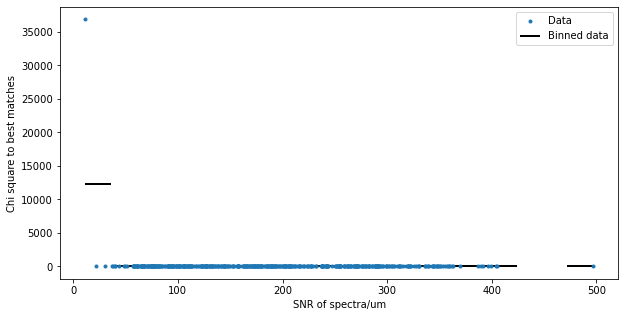

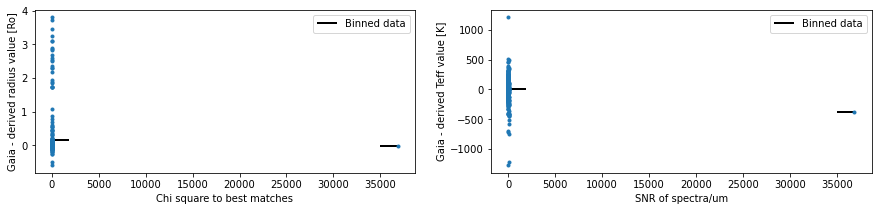

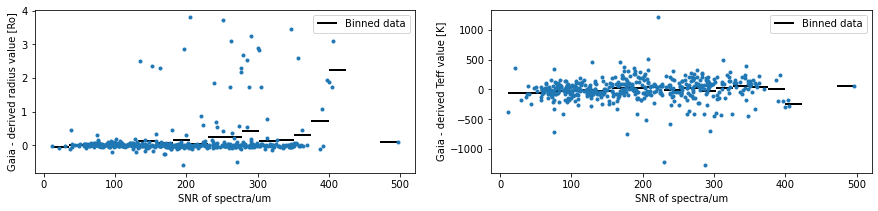

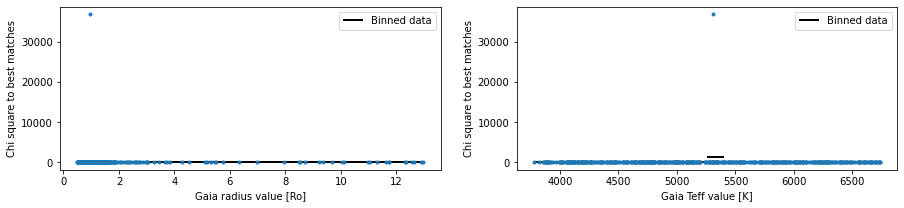

<Figure size 1080x216 with 0 Axes>

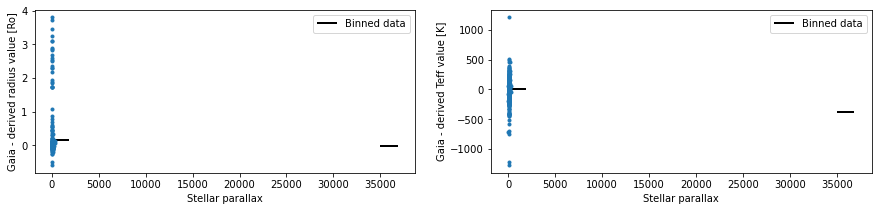

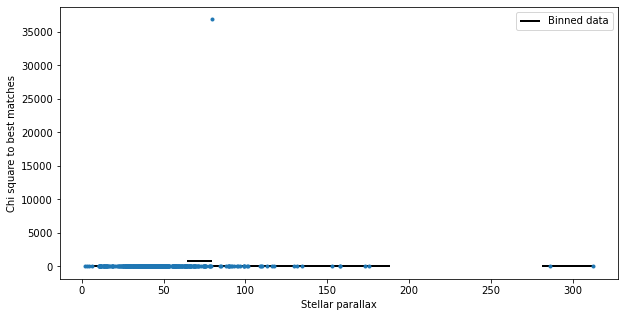

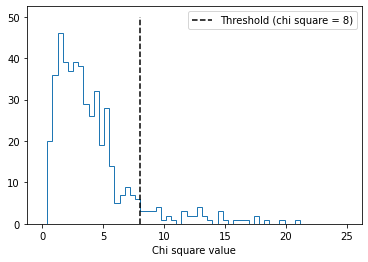

In [17]:
# plot accuracy as a function of chi square
outlier = 449
from scipy import stats
chi_sq = apf_results['best_mean_chi_squared']
SNR = apf_results['SNR']
plt.figure(figsize = [10,5])
plt.plot(np.hstack([SNR[0:outlier],SNR[outlier+1:]]), np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]),'.', label = 'Data') # omit TIC332064670 becuase this is has a hugely large chi sq...
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([SNR[0:outlier],SNR[outlier+1:]]), np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.xlabel('SNR of spectra/um')
plt.ylabel('Chi square to best matches')
plt.figure(figsize = [15,3])
plt.subplot(121)
plt.plot(np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]),np.hstack([delta_R_iso[0:outlier],delta_R_iso[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), np.hstack([delta_R_iso[0:outlier],delta_R_iso[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.xlabel('Chi square to best matches')
plt.ylabel('Gaia - derived radius value [Ro]')
#plt.figure(figsize = [10,5])
plt.subplot(122)
plt.plot(np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), np.hstack([delta_Teff_iso[0:outlier],delta_Teff_iso[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), np.hstack([delta_Teff_iso[0:outlier],delta_Teff_iso[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.xlabel('SNR of spectra/um')
plt.ylabel('Gaia - derived Teff value [K]')
plt.figure(figsize = [15,3])
plt.subplot(121)
plt.plot(np.hstack([SNR[0:outlier],SNR[outlier+1:]]),np.hstack([delta_R_iso[0:outlier],delta_R_iso[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([SNR[0:outlier],SNR[outlier+1:]]), np.hstack([delta_R_iso[0:outlier],delta_R_iso[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.xlabel('SNR of spectra/um')
plt.ylabel('Gaia - derived radius value [Ro]')
#plt.figure(figsize = [10,5])
plt.subplot(122)
plt.plot(np.hstack([SNR[0:outlier],SNR[outlier+1:]]), np.hstack([delta_Teff_iso[0:outlier],delta_Teff_iso[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([SNR[0:outlier],SNR[outlier+1:]]), np.hstack([delta_Teff_iso[0:outlier],delta_Teff_iso[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.xlabel('SNR of spectra/um')
plt.ylabel('Gaia - derived Teff value [K]')
plt.figure(figsize = [15,3])
plt.subplot(121)
plt.plot(np.hstack([gaia_data['radius_val'][0:outlier],gaia_data['radius_val'][outlier+1:]]),np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([gaia_data['radius_val'][0:outlier],gaia_data['radius_val'][outlier+1:]]),np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.ylabel('Chi square to best matches')
plt.xlabel('Gaia radius value [Ro]')
#plt.figure(figsize = [10,5])
plt.subplot(122)
plt.plot(np.hstack([gaia_data['teff_val'][0:outlier],gaia_data['teff_val'][outlier+1:]]),np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([gaia_data['teff_val'][0:outlier],gaia_data['teff_val'][outlier+1:]]),np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.ylabel('Chi square to best matches')
plt.xlabel('Gaia Teff value [K]')
plt.figure(figsize = [15,3])
# by parallax
plt.figure(figsize = [15,3])
plt.subplot(121)
plt.plot(np.hstack([gaia_data['parallax'][0:outlier],gaia_data['parallax'][outlier+1:]]),np.hstack([delta_R_iso[0:outlier],delta_R_iso[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), np.hstack([delta_R_iso[0:outlier],delta_R_iso[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.xlabel('Stellar parallax')
plt.ylabel('Gaia - derived radius value [Ro]')
#plt.figure(figsize = [10,5])
plt.subplot(122)
plt.plot(np.hstack([gaia_data['parallax'][0:outlier],gaia_data['parallax'][outlier+1:]]), np.hstack([delta_Teff_iso[0:outlier],delta_Teff_iso[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), np.hstack([delta_Teff_iso[0:outlier],delta_Teff_iso[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.xlabel('Stellar parallax')
plt.ylabel('Gaia - derived Teff value [K]')
plt.figure(figsize = [10,5])
plt.plot(np.hstack([gaia_data['parallax'][0:outlier],gaia_data['parallax'][outlier+1:]]), np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]),'.')
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(np.hstack([gaia_data['parallax'][0:outlier],gaia_data['parallax'][outlier+1:]]), np.hstack([chi_sq[0:outlier],chi_sq[outlier+1:]]), statistic='mean', bins=20)
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='k', lw=2, label='Binned data')
plt.legend()
plt.xlabel('Stellar parallax')
plt.ylabel('Chi square to best matches')

plt.figure()
plt.hist(chi_sq, bins = np.linspace(0,25,60),histtype = 'step')
plt.vlines([8], ymin = 0, ymax = 50, ls = 'dashed', label = 'Threshold (chi square = 8)')
plt.xlabel('Chi square value')
plt.legend()


In [20]:
# look at the very worst ones
idxs_worst_R = np.where(np.abs(delta_R_iso) > np.percentile(delta_R_iso, 98))[0]
idxs_worst_Teff = np.where(np.abs(delta_Teff_iso) > np.percentile(delta_Teff_iso, 99))[0]
apf_results.iloc[idxs_worst_R,:]['iso_radius']

473    5.559
507    8.933
98     5.598
477    9.162
731    9.190
611    2.577
109    2.325
711    9.216
142    9.312
195    9.250
Name: iso_radius, dtype: float64

/home/azuckerman/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Text(0.5, 1.0, 'delta T > 200')

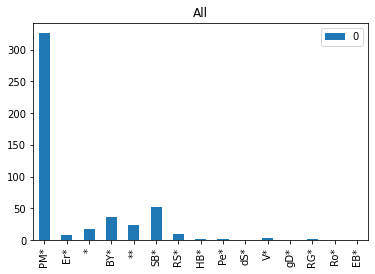

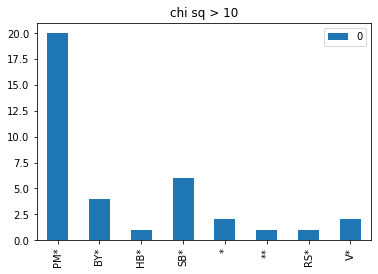

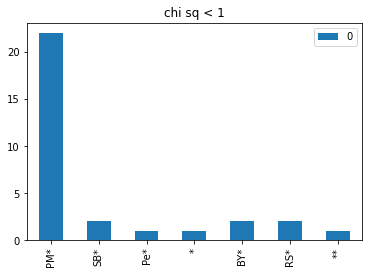

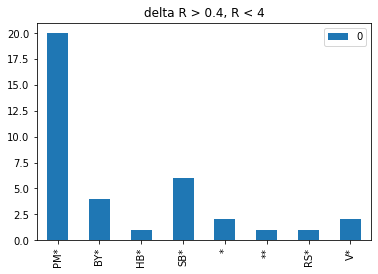

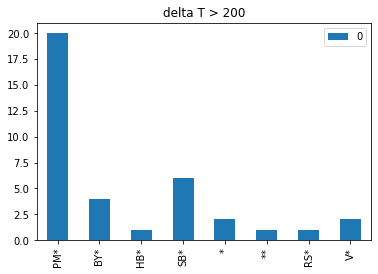

In [159]:
import numpy as np

import pandas
from collections import Counter

types = apf_results['Type'].to_list()
counts = Counter(types)
df = pandas.DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar')
plt.title('All')

idxs_worst_chi_sq = np.where(np.abs(chi_sq) > 10) #np.percentile(chi_sq, 98))[0]
bad_types = apf_results.iloc[idxs_worst_chi_sq]['Type'].to_list()
counts = Counter(bad_types)
df = pandas.DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar')
plt.title('chi sq > 10')

idxs_best_chi_sq = np.where(np.abs(chi_sq) < 1) #np.percentile(chi_sq, 98))[0]
good_types = apf_results.iloc[idxs_best_chi_sq]['Type'].to_list()
counts = Counter(good_types)
df = pandas.DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar')
plt.title('chi sq < 1')

idxs_worst_R = np.where((np.abs(delta_R_iso) > 0.4) * (gaia_data['radius_val'] < 4)) #np.percentile(chi_sq, 98))[0]
bad_types = apf_results.iloc[idxs_worst_chi_sq]['Type'].to_list()
counts = Counter(bad_types)
df = pandas.DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar')
plt.title('delta R > 0.4, R < 4')

idxs_worst_T = np.where(np.abs(delta_Teff_iso) > 200) #np.percentile(chi_sq, 98))[0]
bad_types = apf_results.iloc[idxs_worst_chi_sq]['Type'].to_list()
counts = Counter(bad_types)
df = pandas.DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar')
plt.title('delta T > 200')

### Testing

In [16]:
gaia_source_id, id_2MASS = 	2430036837596487424, np.nan #get_names('HIP101345')
#gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
gaia_row = query_gaia_data(gaia_source_id)
#gaia_row = gaia_row.median(axis = 0, skipna = True)
gaia_row = gaia_row.to_pandas()

In [26]:
np.nanmedian(gaia_row['teff_val'])

4445.0

In [28]:
gaia_source_id = 2430036837596487424
gaia_values = pd.read_csv('gaia_values.csv')
if gaia_values['source_id'].isin([gaia_source_id]).any(): # if this star already exists in the gaia csv file
    gaia_data = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)]
gaia_data

,Unnamed: 0,source_id,ra,dec,parallax,parallax_error,teff_val,radius_val
0,0,2430036837596487424,5.305589,-8.281144,1.299757,0.04888,4445.0,22.816832
1,0,2430036837596487424,5.305589,-8.281144,1.299757,0.04888,4445.0,22.816832
2,0,2430036837596487424,5.305589,-8.281144,1.299757,0.04888,4445.0,22.816832


In [29]:
gaia_Teff = np.nanmedian(gaia_data['teff_val'])
gaia_Teff

4445.0

In [31]:
int((gaia_Teff < 3056) or (gaia_Teff > 6738))

1

(0.0, 0.55)

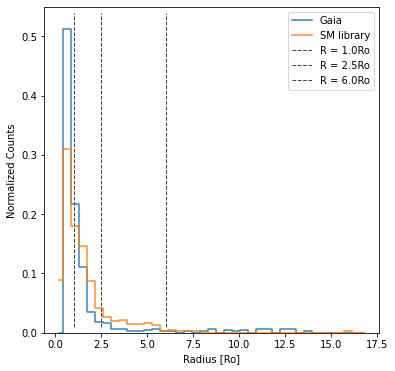

In [125]:
plt.figure(figsize = [6,6])
bins = np.linspace(0,17,40)
values, bins = np.histogram(gaia_data['radius_val'].to_numpy(), bins = bins)
bincenters= [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
plt.step(bincenters,values/len(gaia_data['radius_val'].to_numpy()),where='mid', label = 'Gaia', alpha = 0.9)
values, bin_edges = np.histogram(yee_data['R* [Rsun]'], bins = bins)
bincenters= [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
plt.step(bincenters,values/len(yee_data['R* [Rsun]']),where='mid', label = 'SM library', alpha = 0.9)
plt.vlines([1], ymin = 0.01, ymax = 0.54, label = 'R = 1.0Ro', lw = 1, alpha = 0.75, ls = 'dashed')
plt.vlines([2.5], ymin = 0.01, ymax = 0.54, label = 'R = 2.5Ro', lw = 1, alpha = 0.75, ls = 'dashed')
plt.vlines([6], ymin = 0.01, ymax = 0.54, label = 'R = 6.0Ro', lw = 1, alpha = 0.75, ls = 'dashed')
plt.ylabel('Normalized Counts')
plt.xlabel('Radius [Ro]')
plt.legend()
plt.ylim([0,0.55])


(array([ 61., 113.,  69.,  48.,  33.,  19.,  11.,   6.,   6.,   9.,   5.,
          5.,   8.,   4.,   1.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.168   ,  0.558325,  0.94865 ,  1.338975,  1.7293  ,  2.119625,
         2.50995 ,  2.900275,  3.2906  ,  3.680925,  4.07125 ,  4.461575,
         4.8519  ,  5.242225,  5.63255 ,  6.022875,  6.4132  ,  6.803525,
         7.19385 ,  7.584175,  7.9745  ,  8.364825,  8.75515 ,  9.145475,
         9.5358  ,  9.926125, 10.31645 , 10.706775, 11.0971  , 11.487425,
        11.87775 , 12.268075, 12.6584  , 13.048725, 13.43905 , 13.829375,
        14.2197  , 14.610025, 15.00035 , 15.390675, 15.781   ]),
 <a list of 40 Patch objects>)

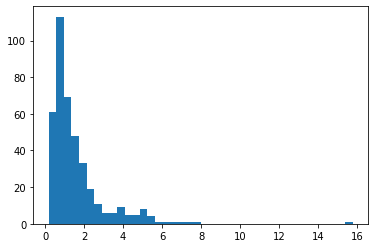

In [93]:
plt.hist(yee_data['R* [Rsun]'], bins = 40)

In [247]:
gaia_data['parallax']

0      61.178262
1      43.976930
2      47.370340
3      38.901379
4      37.875326
         ...    
483    37.739886
484    39.177967
485    40.333928
486    33.190521
487    42.746428
Name: parallax, Length: 488, dtype: float64

In [1]:
plt.hist(yee_data['R* [Rsun]'], bins = 40)

NameError: name 'plt' is not defined

In [95]:
tf_arr = np.zeros(len(apf_results))
tf_arr[[i for i, s in enumerate(apf_results['Type']) if ('*' not in s)]] = 1
apf_results[tf_arr.astype(bool)]

,name,HIP_name,Simbad_resolvable_name,filenames,SNR,iodine_flag,binary_flag,non-stellar_flag,failure_code,failure_message,...,u_age,age_detrended,u_age_detrended,iso_age,iso_up_age,iso_um_age,best_mean_chi_squared,timestamp,Type,Types_list


In [92]:
apf_results['Type']

723    PM*
505    PM*
192    Er*
426      *
343    PM*
      ... 
470     **
147    PM*
626    EB*
469    PM*
639    PM*
Name: Type, Length: 488, dtype: object

In [90]:
from astroquery.simbad import Simbad
#Simbad.add_votable_fields('otypes')
#Simbad.add_votable_fields('otype(3)')
result_table = Simbad.query_object('LP 54-19')
results = result_table.to_pandas()
otypes = results['OTYPES']
otypes_list = results['OTYPES'][0].split('|')
#'SB*' in otypes_list #== 'err' # not an object
otype = results['OTYPE_3'][0]
otype

'SB*'

In [86]:
Simbad.reset_votable_fields()

In [99]:
np.where(bad_objects_mask)

(array([ 19,  34,  62,  63,  64,  66,  78,  96, 117, 126, 135, 145, 160,
        166, 176, 178, 179, 181, 182, 188, 198, 209, 220, 221, 222, 231,
        239, 250, 257, 260, 273, 285, 306, 336, 337, 341, 344, 361, 362,
        367, 383, 390, 397, 402, 403, 404, 405, 411, 419, 440, 468, 478,
        481]),)

In [109]:
#gaia_data.iloc[np.where(bad_objects_mask)[0],:]
gaia_data['teff_val']#[bad_objects_mask]

0      4255.0063
1      5083.3930
2      4787.3335
3      5867.3335
4      4188.4497
         ...    
483    4100.0000
484    5726.0000
485    4259.3100
486    4098.1330
487    4751.0723
Name: teff_val, Length: 488, dtype: float64

In [111]:
bad_objects_mask.to_numpy()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False,

In [131]:
gaia_data['teff_val'][mask].iloc[19]

4747.5

In [137]:
gaia_data['radius_val'][mask].iloc[row]

0.67435205

In [163]:
len(np.where(mask)[0])

435

In [40]:
yee_data

,Name,Teff [K],e_Teff [K],R* [Rsun],e_R* [Rsun],log(g) [cm/s2],e_log(g) [cm/s2],[Fe/H] [sun],e_[Fe/H] [sun],M* [Msun],...,e_logAge [yr],plx [mas],Vmag [mag],Notes,SCat,Gaia,2M,Simbad,_RA [deg],_DE [deg]
0,HD 100623,5140,60,0.720,0.040,4.56,0.05,-0.36,0.05,0.75,...,0.50,104.6,6.0,"A,1",1,Gaia,2M,Simbad,173.62286,-32.83134
1,HD 101904,5883,60,1.540,0.190,4.10,0.05,0.12,0.05,1.12,...,0.11,12.5,8.2,"A,1",1,Gaia,2M,Simbad,176.00117,64.96420
2,HD 102195,5277,60,0.850,0.050,4.50,0.05,0.10,0.05,0.89,...,0.49,34.0,8.1,"A,1",1,Gaia,2M,Simbad,176.42622,2.82148
3,HD 102444,5227,60,2.670,0.390,3.60,0.05,0.00,0.05,1.02,...,0.27,8.5,8.0,"A,1",1,Gaia,2M,Simbad,176.88109,-5.26362
4,HD 102956,4985,60,3.790,0.470,3.38,0.05,0.26,0.05,1.30,...,0.17,8.1,7.9,"A,1",1,Gaia,2M,Simbad,177.84380,57.64073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,GL 702B,4393,149,0.670,0.009,4.64,0.02,0.03,0.10,0.71,...,0.52,,7.2,"E,3",0,Gaia,2M,Simbad,271.36425,2.49901
400,GL 876,3129,19,0.376,0.006,4.88,0.01,0.19,0.10,0.35,...,0.41,214.1,10.2,"E,1",1,Gaia,2M,Simbad,343.31972,-14.26370
401,HIP 57087,3416,53,0.455,0.018,4.83,0.03,0.04,0.10,0.45,...,0.52,102.6,10.6,"E,1",1,Gaia,2M,Simbad,175.54622,26.70657
402,HIP 74995,3442,54,0.299,0.010,4.97,0.03,-0.10,0.10,0.30,...,0.53,158.6,10.6,"E,1",1,Gaia,2M,Simbad,229.86176,-7.72228
